In [143]:
!pip install --quiet pandas meteomatics scikit-learn python-dotenv

# Fetch weather data from Meteomatics API

In [104]:
import os
import datetime as dt
import pandas as pd
from dateutil.relativedelta import relativedelta
import meteomatics.api as api

from dotenv import load_dotenv

load_dotenv()

MM_USER = os.getenv("METEOMATICS_USER")
MM_PASS = os.getenv("METEOMATICS_PASSWORD")

# Switzerland bbox + grid
LAT_N, LON_W, LAT_S, LON_E = 47.89, 5.77, 45.74, 10.65
RES_LAT, RES_LON = 0.25, 0.25

# Weather parameters (no panel metadata)
parameters = [
    "global_rad:W",
    "direct_rad:W",
    "diffuse_rad:W",
    "effective_cloud_cover:octas",
    "t_2m:C",
    # "dew_point_2m:C",
    "relative_humidity_2m:p",
    "wind_speed_10m:ms",
    "precip_1h:mm",
    "snow_depth:cm",
    "fresh_snow_1h:cm",
    # "msl_pressure:hPa"
]

interval = dt.timedelta(hours=1)
start = dt.datetime(2017, 1, 1)
end   = dt.datetime(2018, 1, 1)

out_dir = "data/processed/meteomatics_weather_hourly_2017"
os.makedirs(out_dir, exist_ok=True)

def month_chunks(a, b):
    cur = a
    while cur < b:
        nxt = cur + relativedelta(months=1)
        yield cur, min(nxt, b)
        cur = nxt

for s, e in month_chunks(start, end):
    print(f"fetch {s} - {e}")
    df = api.query_grid_timeseries(
        s, e, interval,
        parameters,
        LAT_N, LON_W, LAT_S, LON_E,
        RES_LAT, RES_LON,
        MM_USER, MM_PASS,
        request_type="POST",
        interp_select="lapse_rate"
    )

    df = df.reset_index()
    t = df["validdate"].dt.tz_convert("Europe/Zurich")
    df.assign(
        hour       = t.dt.hour,
        dow        = t.dt.dayofweek,
        is_weekend = (t.dt.dayofweek >= 5).astype(int),
        month      = t.dt.month,
        day        = t.dt.day,
        ts_local   = t.dt.tz_localize(None)   # naive local timestamp
    )

    path = os.path.join(out_dir, f"{s:%Y%m%d}_{e:%Y%m%d}.csv")
    df.to_csv(path)


fetch 2017-01-01 00:00:00 - 2017-02-01 00:00:00
fetch 2017-02-01 00:00:00 - 2017-03-01 00:00:00
fetch 2017-03-01 00:00:00 - 2017-04-01 00:00:00
fetch 2017-04-01 00:00:00 - 2017-05-01 00:00:00
fetch 2017-05-01 00:00:00 - 2017-06-01 00:00:00
fetch 2017-06-01 00:00:00 - 2017-07-01 00:00:00
fetch 2017-07-01 00:00:00 - 2017-08-01 00:00:00
fetch 2017-08-01 00:00:00 - 2017-09-01 00:00:00
fetch 2017-09-01 00:00:00 - 2017-10-01 00:00:00
fetch 2017-10-01 00:00:00 - 2017-11-01 00:00:00
fetch 2017-11-01 00:00:00 - 2017-12-01 00:00:00
fetch 2017-12-01 00:00:00 - 2018-01-01 00:00:00


# ML model (simple)

## Read data

In [138]:
import pandas as pd


# energy consumption
df_con = (
    pd.read_csv("data/raw/ogd103_stromverbrauch_swissgrid_lv_und_endv.csv")
      .rename(columns={
          "Datum": "date",
          "Landesverbrauch_GWh": "national_consumption_gwh",
          "Endverbrauch_GWh": "end_consumption_gwh",
      })
      .dropna(subset=["date"])
)
df_con["date"] = pd.to_datetime(df_con["date"])

# PV production
df_pv = (
    pd.read_csv("data/raw/ogd104_stromproduktion_swissgrid.csv")
      .rename(columns={
          "Datum": "date",
          "Energietraeger": "energy_carrier",
          "Produktion_GWh": "production_gwh",
      })
)
df_pv = (
    df_pv[df_pv["energy_carrier"].str.lower().eq("photovoltaik")]
      .drop(columns=["energy_carrier"])
)
df_pv["date"] = pd.to_datetime(df_pv["date"])
df_pv = df_pv.groupby("date", as_index=False)["production_gwh"].sum() \
             .rename(columns={"production_gwh": "pv_production_gwh"})

# weather
df_w = pd.concat(
    [
        pd.read_csv(
            os.path.join(out_dir, f),
            parse_dates=["validdate"]   # 👈 convert to datetime
        )
        for f in os.listdir(out_dir)
        if f.endswith(".csv")
    ],
    ignore_index=True
)
df_w["date"] = pd.to_datetime(df_w["validdate"]).dt.date
df_w = df_w.groupby("date").agg({
    "global_rad:W": ["sum", "mean"],
    "t_2m:C": ["min", "max", "mean"],
    "relative_humidity_2m:p": "mean",
    "wind_speed_10m:ms": "mean",
    "precip_1h:mm": "sum",
    "snow_depth:cm": "mean",
    "effective_cloud_cover:octas": "mean"
})
df_w.columns = ["_".join(c) for c in df_w.columns]
df_w = df_w.reset_index().rename(columns={"date": "date"})
df_w["date"] = pd.to_datetime(df_w["date"])
df_w["month"] = df_w["date"].dt.month
df_w["dow"] = df_w["date"].dt.dayofweek
df_w["is_weekend"] = (df_w["dow"] >= 5).astype(int)

# join weather + consumption + pv on date
df_all = (
    df_w.merge(df_con, on="date", how="left")
       .merge(df_pv, on="date", how="left")
       .sort_values("date")
       .reset_index(drop=True)
)

df_all.head()


,date,global_rad:W_sum,global_rad:W_mean,t_2m:C_min,t_2m:C_max,t_2m:C_mean,relative_humidity_2m:p_mean,wind_speed_10m:ms_mean,precip_1h:mm_sum,snow_depth:cm_mean,effective_cloud_cover:octas_mean,month,dow,is_weekend,national_consumption_gwh,end_consumption_gwh,pv_production_gwh
0,2017-01-01,307321.9,71.139329,-13.8,9.7,0.192963,42.000532,1.355556,0.49,8.436806,0.099306,1,6,1,170.0,150.0,2.2
1,2017-01-02,209969.3,48.604005,-17.6,8.4,-1.618032,62.604028,1.814375,141.26,8.566667,3.742361,1,0,0,179.0,162.0,1.6
2,2017-01-03,304991.3,70.599838,-21.3,7.1,-3.866273,65.697778,2.035000,8.53,9.044213,0.545370,1,1,0,200.0,183.0,2.0
3,2017-01-04,165737.3,38.365116,-22.3,10.8,-2.784491,69.839537,3.648843,602.13,9.791667,3.804398,1,2,0,202.0,188.0,1.2
4,2017-01-05,196172.9,45.410394,-27.5,4.9,-7.108773,72.939190,3.712014,438.01,12.603009,2.643981,1,3,0,207.0,190.0,1.3


pv_production_gwh: MAE=0.622 | R2=-0.311


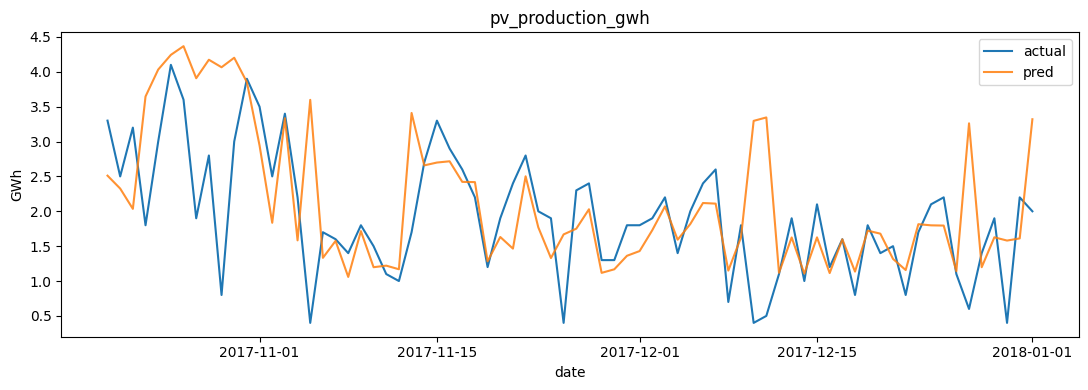

national_consumption_gwh: MAE=5.204 | R2=0.805


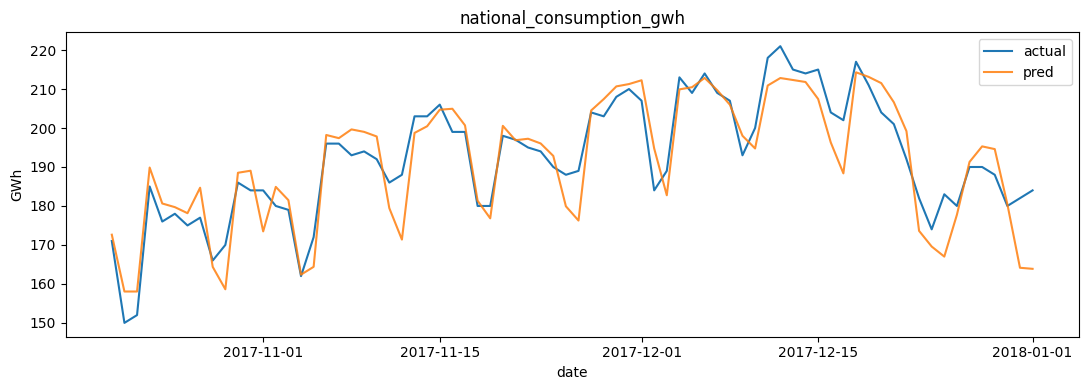

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

df = df_all.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

targets = ["pv_production_gwh", "national_consumption_gwh"]
drop_cols = set(["date"]) | set(targets)
feature_cols = [c for c in df.columns if c not in drop_cols]

for target in targets:
    dft = df.dropna(subset=[target]).reset_index(drop=True)
    X = dft[feature_cols]
    y = dft[target]
    t = dft["date"]

    X_train, X_val, y_train, y_val, t_train, t_val = train_test_split(
        X, y, t, test_size=0.2, shuffle=False
    )

    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    print(f"{target}: MAE={mean_absolute_error(y_val, y_pred):.3f} | R2={r2_score(y_val, y_pred):.3f}")

    plt.figure(figsize=(11,4))
    plt.plot(t_val, y_val.values, label="actual")
    plt.plot(t_val, y_pred, label="pred", alpha=0.85)
    plt.title(f"{target}")
    plt.xlabel("date"); plt.ylabel("GWh"); plt.legend(); plt.tight_layout()
    plt.show()
